Try implementing MMD GAN on simple datasets: 2d points

In [1]:
# import dependencies
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

cpu


## Toy Dataset

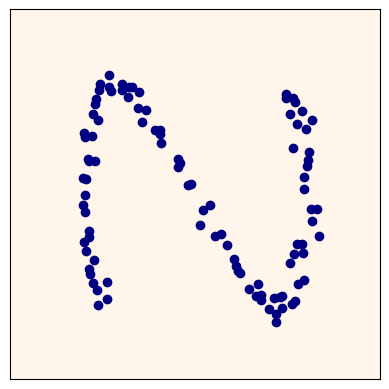

In [2]:
d = 2   # dimension of the data points

# # First dataset with 6 points
# n = 6
# y = torch.zeros((n,d), device=device)
# y[0, 0] = 0.9
# y[0, 1] = 0.2
# y[1, 0] = 0.75
# y[1, 1] = 0.8
# y[2, 0] = 0.3
# y[2, 1] = 0.4
# y[3, 0] = 0.4
# y[3, 1] = 0.7
# y[4, 0] = 0.45
# y[4, 1] = 0.75
# y[5, 0] = 0.7
# y[5, 1] = 0.5

# Second dataset with 100 points, we use this for the rest of the 
n = 100
t = torch.pi*torch.linspace(-.2,1.2,n)
y = .05*torch.randn((n,d))
y[:,0] += torch.cos(t)
y[:,1] += torch.sin(2*t)
y = .5 + .3*y
y = y.to(device)

# Define masses (empirical measure on the data points)
nu = torch.ones(n, device=device)/n

# generate grid for plotting purpose
nr,nc = 256,256
extent = ((-0.5/nc, 1-0.5/nc, 1-0.5/nr, -0.5/nr))
xs = torch.linspace(0, 1, steps=nr)
ys = torch.linspace(0, 1, steps=nc)
xm, ym = torch.meshgrid(xs, ys, indexing='ij')
xm = xm.T
ym = ym.T
xgrid = torch.cat((xm.reshape(nr*nc,1),ym.reshape(nr*nc,1)),1).to(device)

# Plot data points
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

## Generator

In [3]:
class Generator(torch.nn.Module):
    def __init__(self, n_z, n_hidden, n_out, device=torch.device('cpu')):
        super(Generator, self).__init__()
        self.device = device
        self.n_z = n_z # the dimension of the latent space
        self.n_hidden = n_hidden # the dimension of the hidden layer
        self.n_out = n_out # the dimension of the output, for 2d points, n_out=2
        self.fc1 = nn.Linear(n_z, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_hidden)
        self.fc4 = nn.Linear(n_hidden, n_out)
        
    def forward(self, z):
        # use ELU for the activation function
        h1 = F.elu(self.fc1(z))
        h2 = F.elu(self.fc2(h1))
        h3 = F.elu(self.fc3(h2))
        # and sigmoid for the output layer
        return torch.sigmoid(self.fc4(h3))
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight, 1.0)
            if module.bias is not None:
                module.bias.data.zero_()

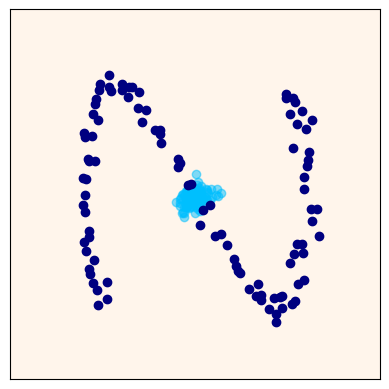

In [4]:
# plot initial config of the generator
n_z = 10
n_hidden = 100
n_out = d

G = Generator(n_z, n_hidden, n_out, device=device).to(device)

# generate a batch of noise
b = 100
z = torch.randn(b, n_z, device=device)
# use generator to generate x
x = G(z)

# Plot
xd = x.detach()
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

## Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self, n_x, n_hid=10):
        super(Discriminator, self).__init__()
        self.n_hid = n_hid
        self.n_x = n_x
        
        self.fc1 = nn.Linear(n_x, n_hid)
        self.fc2 = nn.Linear(n_hid, n_hid)
        self.fc3 = nn.Linear(n_hid,1)
        
    def forward(self, x):
        h1 = F.elu(self.fc1(x))
        h2 = F.elu(self.fc2(h1))
        return torch.sigmoid(self.fc3(h2))

In [6]:
# verify the input and output dimension of the discriminator
n_x = d
D = Discriminator(n_x, n_hid=10).to(device)

# generate a batch of data points
b = 100
x = torch.randn(b, n_x, device=device)
# use discriminator to get the probability of being real
p = D(x)

p

tensor([[0.5004],
        [0.5151],
        [0.5037],
        [0.5044],
        [0.5152],
        [0.5137],
        [0.5078],
        [0.5306],
        [0.5132],
        [0.5223],
        [0.5154],
        [0.5134],
        [0.5204],
        [0.5082],
        [0.5151],
        [0.5160],
        [0.5194],
        [0.5166],
        [0.5152],
        [0.5133],
        [0.5238],
        [0.5118],
        [0.5204],
        [0.5166],
        [0.5124],
        [0.5167],
        [0.5182],
        [0.5156],
        [0.5160],
        [0.5181],
        [0.5138],
        [0.5213],
        [0.5242],
        [0.5161],
        [0.5337],
        [0.5119],
        [0.5000],
        [0.5150],
        [0.5010],
        [0.5237],
        [0.5165],
        [0.5291],
        [0.5175],
        [0.5214],
        [0.5142],
        [0.5144],
        [0.5139],
        [0.5162],
        [0.5103],
        [0.5180],
        [0.5075],
        [0.5146],
        [0.5051],
        [0.5151],
        [0.5133],
        [0

## MMD Loss

For 2d points, we use a simple linear kernel or Gaussian kernel.

In [8]:
y.shape

torch.Size([100, 2])

In [9]:
x.shape

torch.Size([100, 2])

In [10]:
(x-y).shape

torch.Size([100, 2])

In [62]:
def k_linear(X, Y):
    """
    simple <X, Y> kernel
    """
    return torch.mm(X, Y.t()).sum()

In [75]:
def k_linear_element(a,b):
    """
    a and b are both 2d points, return the ||a-b||^2
    """
    return (a-b).pow(2).sum()

In [76]:
def MMD2_linear_element(X, Y):
    m = X.shape[0] # assume that X and Y have the same number of points
    # K_XX
    K_XX = 0
    for i in range(m):
        for j in range(m):
            K_XX += k_linear_element(X[i], X[j])
    K_XX = K_XX/(m*(m-1))
    # K_YY
    K_YY = 0
    for i in range(m):
        for j in range(m):
            K_YY += k_linear_element(Y[i], Y[j])
    K_YY = K_YY/(m*(m-1))
    # K_XY
    K_XY = 0
    for i in range(m):
        for j in range(m):
            K_XY += k_linear_element(X[i], Y[j])
    K_XY = K_XY/(m*m)
    return K_XX + K_YY - 2*K_XY

In [ ]:
# X[:, None...

In [79]:
# test the MMD2_linear_element
MMD2_linear_element(x, y)

tensor(-1.0375)

In [29]:
def k_gaussian(X, Y, sigma):
    """
    Compute the Gaussian kernel matrix between two sets of points X and Y
    """
    # number of samples
    nx = X.shape[0] # for 2d points, X shape is (n, 2)
    ny = Y.shape[0]
    # compute the kernel
    XX = torch.sum(X*X, 1).view(-1, 1)
    YY = torch.sum(Y*Y, 1).view(-1, 1)
    XY = torch.mm(X, Y.t())
    # compute the pairwise distance
    D = XX + YY - 2*XY
    return torch.exp(-D/(2*sigma**2)).sum()/(nx*ny)

In [31]:
# test the Gaussian kernel
sigma = 0.5
k_gaussian(x, y, sigma)

tensor(0.2397)

In [63]:
def k_gaussian_list(X, Y, sigma_list):
    """
    Compute the list of Gaussian kernel matrix between two sets of points X and Y
    """
    K = 0
    for sigma in sigma_list:
        K += k_gaussian(X, Y, sigma)
    return K

In [64]:
def MMD2_linear(X, Y):
    """
    Compute the MMD^2 between two sets of points X and Y
    """
    m = X.shape[0]
    return k_linear(X, X)/(m*(m-1)) + k_linear(Y, Y)/(m*(m-1)) - 2*k_linear(X, Y)/(m*m)

In [43]:
def MMD2(X, Y, sigma_list):
    """
    Compute the MMD^2 between two sets of points X and Y
    """
    m = X.shape[0]
    return k_gaussian_list(X, X, sigma_list)/(m*(m-1)) + k_gaussian_list(Y, Y, sigma_list)/(m*(m-1)) - 2*k_gaussian_list(X, Y, sigma_list)/(m*m)

In [60]:
# test the MMD2_linear
MMD2_linear(x, y)

tensor(5.4335e-05)

In [66]:
def linear_mmd2(f_of_X, f_of_Y):
    loss = 0.0
    delta = f_of_X - f_of_Y
    loss = torch.mean((delta[:-1] * delta[1:]).sum(1))
    return loss

In [54]:
# test the MMD2
sigma_list = [0.5, 0.8,1, 4]
MMD2(x, y, sigma_list)

tensor(0.0250)

ODG sigma, mean distance between X and Y

## Training the MMD GAN

Epoch [1/10], Loss Discriminator: -0.0021, Loss Generator: -0.0293


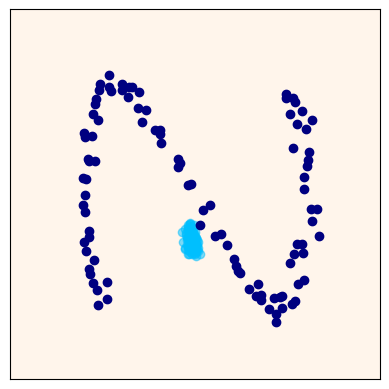

Epoch [2/10], Loss Discriminator: -0.0391, Loss Generator: -0.1114


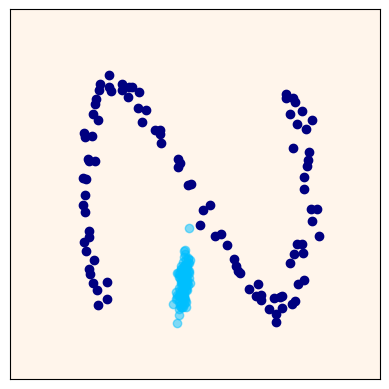

Epoch [3/10], Loss Discriminator: -0.1361, Loss Generator: -0.2725


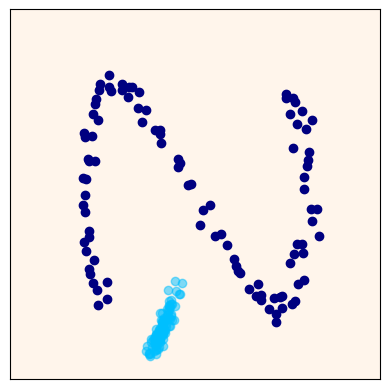

Epoch [4/10], Loss Discriminator: -0.3176, Loss Generator: -0.4946


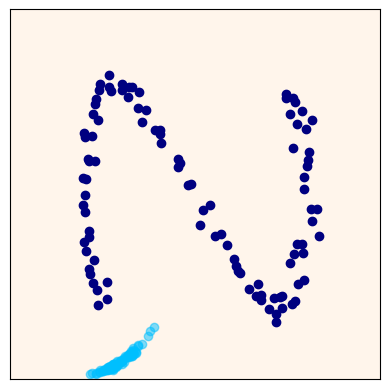

Epoch [5/10], Loss Discriminator: -0.5752, Loss Generator: -0.7695


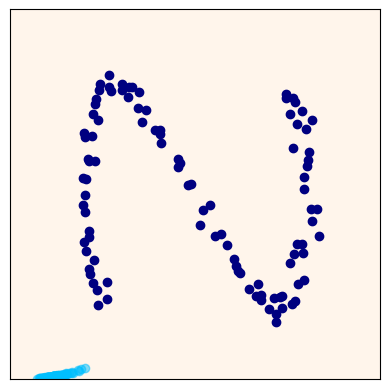

Epoch [6/10], Loss Discriminator: -0.8112, Loss Generator: -0.9340


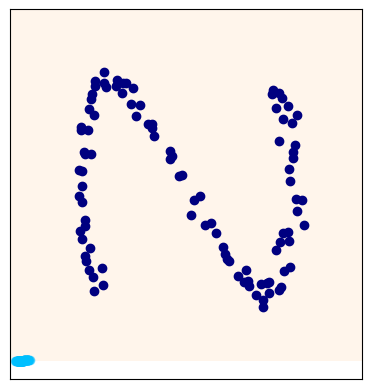

Epoch [7/10], Loss Discriminator: -0.9574, Loss Generator: -0.9862


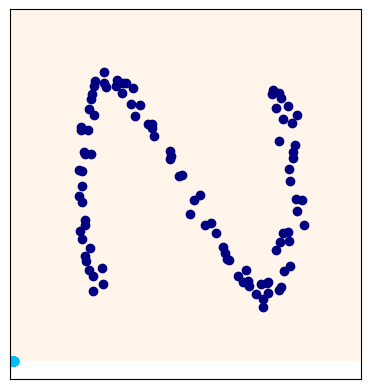

Epoch [8/10], Loss Discriminator: -0.9902, Loss Generator: -0.9958


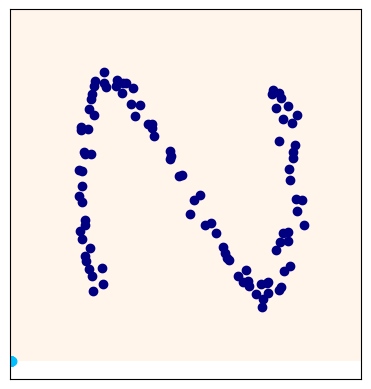

Epoch [9/10], Loss Discriminator: -0.9964, Loss Generator: -0.9979


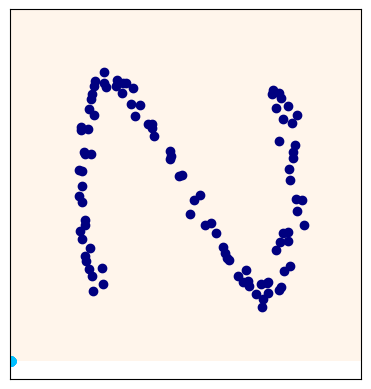

Epoch [10/10], Loss Discriminator: -0.9981, Loss Generator: -0.9984


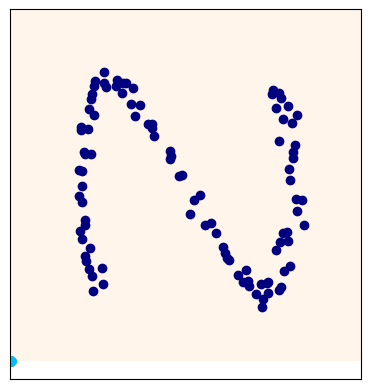

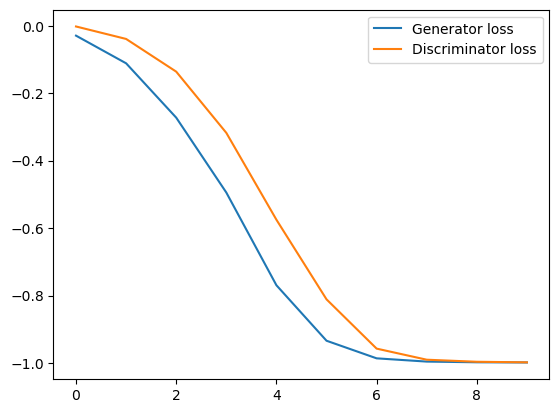

In [86]:
# parameters for training
n_epochs = 10
niterD = 5
niterG = 5
lr_D = 0.001
lr_G = 0.001
n_z = 10
n_hidden = 100
n_out = d
n_x = d
sigma_list =  [0.5, 0.8,1]

torch.manual_seed(42)

# Initialize the generator and the discriminator
G = Generator(n_z, n_hidden, n_out, device=device).to(device)
D = Discriminator(n_x, n_hid=10).to(device)

# Initialize the optimizer
optimizerD = optim.Adam(D.parameters(), lr=lr_D)
optimizerG = optim.Adam(G.parameters(), lr=lr_G)

G_losses = []
D_losses = []

for epoch in range(1, n_epochs+1):
    for iter in range(0, niterD):
        # print(f"iterD: {iter}/{niterD}")
        # update the discriminator
        optimizerD.zero_grad()
        # generate noises
        z = torch.normal(mean=torch.zeros(b, n_z), std=torch.ones(b, n_z)).to(device)
        x_fake = G(z) # generate fake data points
        x_fake_detached = x_fake.detach()
        x_real = y
        # print the shape
        # print("x_fake shape: ", x_fake.shape)
        # print("x_real shape: ", x_real.shape)
        # compute the loss
        lossD = MMD2_linear_element(x_real, x_fake)
        # optimize
        lossD.backward()
        optimizerD.step()
        
    for iter in range(0, niterG):
        # print(f"iterG: {iter}/{niterG}")
        # update the generator
        optimizerG.zero_grad()
        # generate noises
        z = torch.normal(mean=torch.zeros(b, n_z), std=torch.ones(b, n_z)).to(device)
        x_fake = G(z) # generate fake data points
        x_fake_detached = x_fake.detach()
        x_real = y
        # compute the loss
        lossG = MMD2_linear_element(x_real, x_fake)
        # optimize
        lossG.backward()
        optimizerG.step()
        
    G_losses.append(lossG.item())
    D_losses.append(lossD.item())
    
    print('Epoch [{}/{}], Loss Discriminator: {:.4f}, Loss Generator: {:.4f}'.format(epoch, n_epochs, lossD.item(), lossG.item()))
    
    if epoch % 1 == 0:
        # Plot
        xd = x_fake.detach()
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.show()
        
# Plot losses
plt.plot(G_losses, label='Generator loss')
plt.plot(D_losses, label='Discriminator loss')
plt.legend()
plt.show()